<a href="https://colab.research.google.com/github/x1nx3r/image-analysis-learning-journals/blob/main/resnet_50_trial_run_with_4_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Install necessary libraries
!pip install torch torchvision timm
!pip install resnest

In [27]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from resnest.torch import resnest50  # Example, but you can use other variants as needed

In [28]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/dataset/trial-run/'

# Check if the folder exists
data_path = '/content/drive/MyDrive/dataset/trial-run/'
print("Is the directory accessible?", os.path.exists(data_path))

# List files in the directory
print("Files in the dataset folder:", os.listdir(data_path))

train_dir = '/content/drive/MyDrive/dataset/trial-run/train'
valid_dir = '/content/drive/MyDrive/dataset/trial-run/valid'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Is the directory accessible? True
Files in the dataset folder: ['train', 'valid']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.0677, Accuracy: 58.45%
Validation Accuracy: 65.00%
Epoch [2/10], Loss: 0.4785, Accuracy: 85.92%
Validation Accuracy: 70.00%
Epoch [3/10], Loss: 0.2469, Accuracy: 92.25%
Validation Accuracy: 77.50%
Epoch [4/10], Loss: 0.2341, Accuracy: 91.55%
Validation Accuracy: 70.00%
Epoch [5/10], Loss: 0.1343, Accuracy: 97.18%
Validation Accuracy: 62.50%
Epoch [6/10], Loss: 0.1314, Accuracy: 98.59%
Validation Accuracy: 75.00%
Epoch [7/10], Loss: 0.0749, Accuracy: 99.30%
Validation Accuracy: 75.00%
Epoch [8/10], Loss: 0.0733, Accuracy: 98.59%
Validation Accuracy: 72.50%
Epoch [9/10], Loss: 0.0952, Accuracy: 97.18%
Validation Accuracy: 82.50%
Epoch [10/10], Loss: 0.0847, Accuracy: 97.89%
Validation Accuracy: 77.50%
Best Validation Accuracy: 82.50%


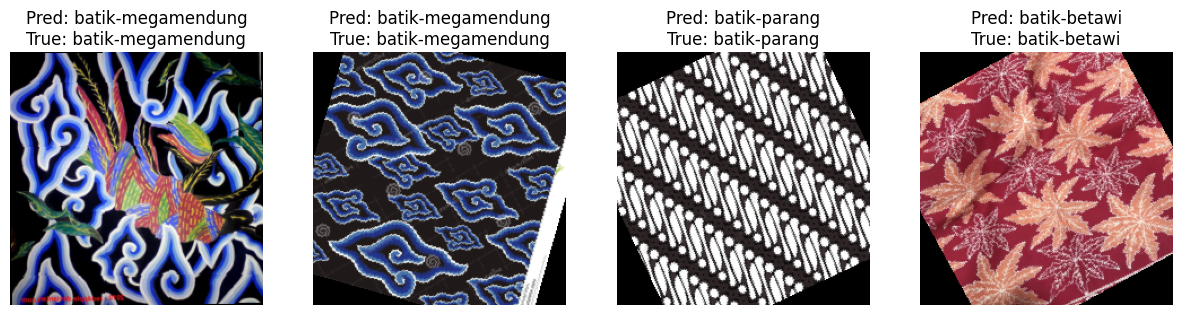

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-50 model from torchvision (or your preferred model)
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # Assuming 4 classes in your dataset
model.to(device)

# Define data augmentation and normalization pipeline
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

# List of class names (ensure the order matches your ImageFolder class order)
class_names = train_dataset.classes  # e.g., ['batik_betawi', 'batik_parang', 'batik_megamendung', 'batik_pekalongan']

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Function to train the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Validation step
        model.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            val_acc = 100 * correct_val / total_val
            print(f"Validation Accuracy: {val_acc:.2f}%")
            # Save the model if it's the best validation accuracy so far
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), 'best_model.pth')

    print(f"Best Validation Accuracy: {best_acc:.2f}%")

# Train the model
train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10)

# Function to perform random test sampling and display predictions
def random_test_sampling(model, loader, class_names, num_samples=4):
    model.eval()
    # Randomly select a batch from the loader
    batch = random.choice(list(loader))
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass on this batch
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

    # Unnormalize images for visualization
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    # Plot random samples from the batch
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    for i in range(num_samples):
        image = inputs[i].cpu()
        image = inv_normalize(image)  # Unnormalize
        image = torch.clamp(image, 0, 1)  # Clip to valid range

        axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axes[i].set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        axes[i].axis('off')
    plt.show()

# Perform random test sampling on the validation set
random_test_sampling(model, valid_loader, class_names, num_samples=4)